In [1]:
import pandas as pd
import json
import numpy as np
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy import spatial
import matplotlib.pyplot as plt
import random

def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

# Data Inladen

In [2]:
# Load data for town called Cleveland
data_path = './data/cleveland/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)

# Split in training & test set. 
training_set = reviews.sample(frac=0.8,random_state=200) # random state is a seed value
test_set = reviews.drop(training_set.index)

In [29]:
display(reviews.head(1))
display(businesses.head(1))
# display(users.head())
display(tips.head(1))
# display(checkins.head())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,qrffudO73zsslZbe8B9D3Q,sG_h0dIzTKWa3Q6fmb4u-g,b2jN2mm9Wf3RcrZCgfo1cg,2.0,1,0,0,I was really looking forward to visiting after...,2015-01-18 14:04:18


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,YNvZdMLXa4q8e9tiE4ge4A,Louis Stokes Cleveland VA Medical Center,10701 E Blvd,Cleveland,OH,44106,41.513554,-81.613752,3.5,11,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Health & Medical, Medical Centers",None


,user_id,business_id,text,date,compliment_count
0,aoO6EXKupIDDDMMK4PG-iw,e7207sqC-pSn6GIf31ikhQ,Birthday breakfast!,2013-02-21 13:29:23,0


## Cosine Sim (Rake) - KeyWords

In [4]:
# Based on / Inspired from:
# https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

def formatted(reviews):
    # Copy dataframe
    formatted_reviews = reviews.copy()

    # Modify dataframe so that every business_id has all reviews in one column
    formatted_reviews = formatted_reviews.groupby(['business_id'])['text'].apply(','.join).reset_index()

    # initializing the new column for key words
    formatted_reviews['Key_words'] = ""

    for index, row in formatted_reviews.iterrows():
        plot = row['text']

        # instantiating Rake, by default it uses english stopwords from NLTK
        # and discards all puntuation characters as well
        r = Rake()

        # extracting the words by passing the text
        r.extract_keywords_from_text(plot)

        # getting the dictionary whith key words as keys and their scores as values
        key_words_dict_scores = r.get_word_degrees()

        # assigning the key words to the new column for the corresponding movie
        row['Key_words'] = list(key_words_dict_scores.keys())
    
    # Make a string of words instead of a list
    formatted_reviews['Key_words'] = formatted_reviews['Key_words'].apply(' '.join)

    # dropping the Plot column
    formatted_reviews.drop(columns = ['text'], inplace = True)
    
    return formatted_reviews
formatted_reviews = formatted(training_set)

In [5]:
display(formatted_reviews)

,business_id,Key_words
0,-1vulUmD1pYf0uvXBY1Fzg,tasty asian dishes complaining great product 8...
1,-5sQihzwgmq7tuAyUh7RSw,drop today friend fake sales target whomever r...
2,-7weOHmN5s487aq-7zMbtw,hire like promised possess careless caterer po...
3,-D8DPlf_b5EBTFhsTjFdZw,babysitters refurbished libraries manage beaut...
4,-DU8jf5nA1_yaOqsKsLqmw,cook always fresh sitting take pizza today sau...
...,...,...
3596,ztG_sG9ugajX9crrzh0UyA,drop ear lady money absolutely disgusting ... ...
3597,zukEQmqI4iFszKNmZLWqUg,show barber shop inside laid stopping obviousl...
3598,zwXi28HGMAI5MyCOBdYtcg,take review true big pig loved mild green sals...
3599,zwgbd9PBsQGmRLA9pyoJeA,issues money school district calls back bank s...


In [6]:
def merge_format(formatted_df, formatted_reviews):
    formatted_reviews = pd.concat([formatted_df, formatted_reviews])
    return formatted_reviews.groupby(['business_id'])['Key_words'].apply(','.join).reset_index()


# Add tips-keywords to review-keywords. 
formatted_tips = formatted(tips)
formatted_reviews = merge_format(formatted_tips, formatted_reviews)

display(formatted_reviews.loc[formatted_reviews['business_id'] == 'xakXdxsdou9baauu8k_lRA'])

,business_id,Key_words
3467,xakXdxsdou9baauu8k_lRA,two hours sitting operate today stalled attent...


In [7]:
# Add categories-keywords to reviews-keywords
categories = businesses.copy()
categories = categories.filter(['business_id', 'categories']).dropna()
categories = categories.rename(columns={"categories": "text"})

formatted_categories = formatted(categories)
formatted_reviews = merge_format(formatted_reviews, formatted_categories)

display(formatted_reviews)

,business_id,Key_words
0,-1vulUmD1pYf0uvXBY1Fzg,"2016 crowd parking 9 16 yet ?,$ 8 street ., fr..."
1,-5sQihzwgmq7tuAyUh7RSw,"business ., envelops baby got steelyard closed..."
2,-7weOHmN5s487aq-7zMbtw,hire like promised possess careless caterer po...
3,-D8DPlf_b5EBTFhsTjFdZw,babysitters refurbished libraries manage beaut...
4,-DU8jf5nA1_yaOqsKsLqmw,"garfield last time ., good pizza love grinders..."
...,...,...
3601,ztG_sG9ugajX9crrzh0UyA,drop ear lady money absolutely disgusting ... ...
3602,zukEQmqI4iFszKNmZLWqUg,show barber shop inside laid stopping obviousl...
3603,zwXi28HGMAI5MyCOBdYtcg,"berea !, bailed community event welcome friend..."
3604,zwgbd9PBsQGmRLA9pyoJeA,issues money school district calls back bank s...


In [8]:
def calculate_cosine_sim(df):
    # Count Vectorize the input-dataframe
    count = CountVectorizer()
    count_matrix = count.fit_transform(df['Key_words'])
    
    # Generating the cosine similarity matrix
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    
    # Link the similarity-array to the correct business_id's and combine to a dataframe
    cosine_sim = pd.DataFrame(columns = df['business_id'], index = df['business_id'], data = cosine_sim)
    return cosine_sim
cosine_sim = calculate_cosine_sim(formatted_reviews)

display(cosine_sim)

business_id,-1vulUmD1pYf0uvXBY1Fzg,-5sQihzwgmq7tuAyUh7RSw,-7weOHmN5s487aq-7zMbtw,-D8DPlf_b5EBTFhsTjFdZw,-DU8jf5nA1_yaOqsKsLqmw,-DYPu72JHFKno3lAaUWyFw,-DkhPijabXuTNvNteIpRPw,-Eu04UHRqmGGyvYRDY8-tg,-F0B5F1YLx7093otwgboxw,-FyieCVSxbl-asl-FVmEew,...,zmyd5noZ9Fcy6d6Yf_PcHQ,zo9fKM_Sty6qGztXKoMPmQ,zpTyaPc6EJ_CoJdBfm_nLg,zqRTnP_JQv94nuoyO7xCQg,zt9yBumFjjnKhaFpnOdOyA,ztG_sG9ugajX9crrzh0UyA,zukEQmqI4iFszKNmZLWqUg,zwXi28HGMAI5MyCOBdYtcg,zwgbd9PBsQGmRLA9pyoJeA,zwuOvY99p2UAOzuj1wAX6A
business_id,,,,,,,,,,,,,,,,,,,,,
-1vulUmD1pYf0uvXBY1Fzg,1.000000,0.134811,0.153647,0.048545,0.158505,0.298202,0.282575,0.298862,0.294879,0.100497,...,0.227169,0.246342,0.119530,0.279131,0.167520,0.131031,0.169744,0.246375,0.123135,0.237444
-5sQihzwgmq7tuAyUh7RSw,0.134811,1.000000,0.099353,0.087695,0.166815,0.151052,0.194082,0.154603,0.161901,0.133540,...,0.183403,0.151271,0.121459,0.212726,0.101536,0.127093,0.169458,0.157245,0.125122,0.186647
-7weOHmN5s487aq-7zMbtw,0.153647,0.099353,1.000000,0.079504,0.154960,0.143307,0.154261,0.140423,0.155229,0.138362,...,0.127776,0.190320,0.098879,0.193469,0.117580,0.125412,0.144224,0.150061,0.145846,0.167445
-D8DPlf_b5EBTFhsTjFdZw,0.048545,0.087695,0.079504,1.000000,0.110474,0.084467,0.093610,0.088369,0.092816,0.037716,...,0.116398,0.057643,0.013885,0.094571,0.047795,0.009686,0.087173,0.059604,0.062578,0.091072
-DU8jf5nA1_yaOqsKsLqmw,0.158505,0.166815,0.154960,0.110474,1.000000,0.192580,0.223282,0.198976,0.223233,0.125345,...,0.215107,0.290382,0.138436,0.264011,0.155498,0.157564,0.188060,0.260643,0.124784,0.212189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ztG_sG9ugajX9crrzh0UyA,0.131031,0.127093,0.125412,0.009686,0.157564,0.162415,0.218474,0.167654,0.198570,0.152700,...,0.136908,0.219589,0.114987,0.194230,0.110828,1.000000,0.149733,0.153567,0.145107,0.181011
zukEQmqI4iFszKNmZLWqUg,0.169744,0.169458,0.144224,0.087173,0.188060,0.183320,0.223173,0.189831,0.185759,0.111055,...,0.240288,0.200495,0.160982,0.225558,0.158325,0.149733,1.000000,0.186474,0.152017,0.237326
zwXi28HGMAI5MyCOBdYtcg,0.246375,0.157245,0.150061,0.059604,0.260643,0.240790,0.276272,0.241394,0.275920,0.104407,...,0.240711,0.285052,0.152001,0.294166,0.155163,0.153567,0.186474,1.000000,0.122838,0.235153


In [9]:
def recommendation(business_id, cosine_sim, k):

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[business_id]).sort_values(ascending = False)

    # getting the indexes of the (k+1) most similar movies (k+1 is used to ignore the input business_id)
    top_recommendations = list(score_series.iloc[1:(k+1)].index)
        
    return top_recommendations

In [11]:

# Create copy dataframe with only three useful columns.
review = reviews.copy()
review = review.filter(['user_id', 'business_id', 'stars'])

# Filter out reviews lower than treshold-stars and sort highest rated to lowest rated.
treshold = 3.5
review = review.loc[(review['stars'] >= treshold)].sort_values(by='stars', ascending=False)

# Create a top-5 list of businesses rated per user 
review = review.groupby(['user_id'])['business_id'].apply(lambda x: list(x)[:5]).reset_index()


# Get recommendations per user based on top-5 list of businesses and add to new dataframe column
rec = []
for row in review['business_id']:
    # N of recommendations that are needed to provide enough recommendations even when user has rated only one business
    MINIMUM = (50//len(row))
    
    recs = {y for x in [recommendation(item, cosine_sim, (MINIMUM)) for item in row] for y in x}
    rec.append(recs)
    
# Add to column    
review['recommended'] = rec

display(review)

,user_id,business_id,recommended
0,--Awhttr0FhVud5prVpVlA,[K6fYrrTorlpXmqutRcrHzg],"{GIfZNMP0oIJCje_Xp0Bgrw, VH2BjFjc9usDquDgoHhpt..."
1,--U0loZF9HaSPRzrGuiWLg,[ks8XsTMTungCk-HUtZleYg],"{Gs_jpJB5f3a1jCQjV7QHQA, HmF1uRRxucvELiPWXXsZP..."
2,--_nP6G2mAHyrEFtIG6ggw,[J1RDyyPxhioqm8c_fi4P4Q],"{GIfZNMP0oIJCje_Xp0Bgrw, H3cMcV9KK3g2pi68lDNsn..."
3,--amZ_cR9Zgu4B1RrAHJyA,"[A7i_H252XydtrK7BUTvoog, LNsZJP6jZ11e0tDljOLPi...","{XUA7xA7myMaCuN6G3xYdIA, VH2BjFjc9usDquDgoHhpt..."
4,-0-R267zNIQDPI9rxJlprQ,[NYOONIzD1T0yY9MuCglwLQ],"{F6FYo3IpVwvAJ04kcwEh_w, evNdyHPR1B8E1aIoUAsGr..."
...,...,...,...
31639,zz8qDpBF_Qup2WIfwbYPOQ,[GIfZNMP0oIJCje_Xp0Bgrw],"{VH2BjFjc9usDquDgoHhptA, H3cMcV9KK3g2pi68lDNsn..."
31640,zzDln8w4vq4ePQgnV0tWFA,[9JUynLfWPwe1X9gsJS6FTA],"{VH2BjFjc9usDquDgoHhptA, GIfZNMP0oIJCje_Xp0Bgr..."
31641,zzL4E_gdoSCtgNhW4BPY8w,[X0mNw8owxgJXrgTBR-7Yfg],"{VH2BjFjc9usDquDgoHhptA, H3cMcV9KK3g2pi68lDNsn..."
31642,zza0WgjmkNbCfE0rLGqhXg,[IoXcQkLpEaiv6S7ITelLWg],"{XUA7xA7myMaCuN6G3xYdIA, VH2BjFjc9usDquDgoHhpt..."


In [25]:
def get_recommended(user_id, n, rec = review):
    # Get set of business_id's that are recommended to the provided user_id
    recs = rec['recommended'].loc[rec['user_id'] == user_id].values
    if len(recs) == 0:
        return pd.DataFrame()
    recs = rec['recommended'].loc[rec['user_id'] == user_id].values[0]
    # Get all the business information and sort on highest rated to lowest rated. Return the top-20 recommendations
    recs = businesses[businesses['business_id'].isin(recs)].sort_values(by='stars', ascending=False)[:20]
    return recs

# TESTS
user_id = 'TfmeVvNr5MiXaJDV9IdULA'
display(businesses[businesses['business_id'].isin(reviews['business_id'].loc[reviews['user_id'] == user_id].values)])
display(get_recommended(user_id, 20, rec = review))

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
286,vdloJPM3bSpQTMlwdFek2A,Butcher and the Brewer,2043 E 4th St,Cleveland,OH,44115,41.499218,-81.690129,4.0,535,1,"{'NoiseLevel': 'u'loud'', 'RestaurantsAttire':...","Pubs, Nightlife, Food, Breweries, Bars, Beer, ...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-0:0', '..."
3323,LvnOhs9Udhyp5adF7Cq98g,Sushi 86,509 Prospect Ave,Cleveland,OH,44115,41.498450,-81.688946,4.0,197,1,"{'RestaurantsDelivery': 'True', 'OutdoorSeatin...","Restaurants, Sushi Bars","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2603,AsVR-X40wAzI7z7oRpsbTA,Cuisine Du Cambodge,13124 Lorain Ave,Cleveland,OH,44111,41.458255,-81.780990,4.5,164,0,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Restaurants, Cambodian, Thai, Vietnamese","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-2..."
3534,228mfqUuGbnCs1kiupJXZw,Map of Thailand,"3710 Payne Ave, Ste 106",Cleveland,OH,44114,41.509323,-81.662193,4.5,183,1,"{'BikeParking': 'True', 'BusinessParking': '{'...","Restaurants, Thai","{'Monday': '11:30-21:0', 'Tuesday': '11:30-21:..."
3187,goZV-PlwLJOB8s5O3GruxA,Bangkok Thai Cuisine,5359 Mayfield Rd,Cleveland,OH,44124,41.520092,-81.486463,4.5,228,1,"{'BusinessParking': '{'garage': False, 'street...","Thai, Noodles, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ..."
526,1gQrMs-I8oKg2p-iRxznzQ,Soho Chicken + Whiskey,1889 W 25th St,Cleveland,OH,44113,41.485563,-81.704142,4.5,385,1,"{'WiFi': ''free'', 'RestaurantsGoodForGroups':...","Nightlife, Breakfast & Brunch, Bars, Restauran...","{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22..."
1031,bupMXFUaZfranBLdaVcRww,Ginko,2247 Professor Ave,Cleveland,OH,44113,41.481615,-81.686368,4.5,252,1,"{'BikeParking': 'True', 'WiFi': 'u'no'', 'Good...","Japanese, Restaurants, Sushi Bars","{'Tuesday': '16:30-22:0', 'Wednesday': '16:30-..."
15,9IJ-TE4HEcAJQkUtc1A_Vw,Parallax Restaurant and Lounge,2179 W 11th St,Cleveland,OH,44113,41.482406,-81.689060,4.0,207,1,"{'RestaurantsPriceRange2': '3', 'RestaurantsDe...","Restaurants, Asian Fusion, Sushi Bars, Thai","{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:..."
1633,nJrFxROYx9sis3acKkhzgA,Lolita,900 Literary Rd,Cleveland,OH,44113,41.481671,-81.687058,4.0,374,0,"{'WiFi': 'u'no'', 'RestaurantsAttire': 'u'casu...","Food, American (New), Specialty Food, Ethnic F...","{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22..."
1652,H3cMcV9KK3g2pi68lDNsng,Luxe Kitchen & Lounge,6605 Detroit Ave,Cleveland,OH,44102,41.483651,-81.730966,4.0,297,1,"{'Alcohol': 'u'full_bar'', 'RestaurantsAttire'...","Vegetarian, Italian, American (New), Restauran...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
2007,J1RDyyPxhioqm8c_fi4P4Q,Lola,2058 E 4th St,Cleveland,OH,44115,41.498793,-81.690258,4.0,1006,1,"{'HappyHour': 'True', 'RestaurantsDelivery': '...","American (New), Bars, Nightlife, Wine Bars, Re...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
2138,cUwNW5NEua_yMcAx-X2sMg,Grumpy's Cafe,2621 W 14th St,Cleveland,OH,44113,41.476519,-81.690993,4.0,341,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Salad, Event Planning & Services, Breakfast & ...","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ..."


# Evaluatie
## MSE

In [13]:
# Create utility matrix with reviews (user, business and stars)
def pivot_utility(df):
    return df.pivot_table(values='stars', columns='user_id', index='business_id', aggfunc='mean')
utility = pivot_utility(test_set)
display(utility)

user_id,--U0loZF9HaSPRzrGuiWLg,--amZ_cR9Zgu4B1RrAHJyA,-0S_XaK3Q_Mesal2Unta2w,-0YN7DR3V0ynR9ureBeOKA,-0cu1eLTYG-TJCer9VVF9A,-0x2ov-qcCopv32Imm-TYg,-14qTFhM3qDTqMbTpYxe3A,-1YGFe7qDm2yl43AqCbMNg,-1kZ1AjX3ycFVRllm7BCDg,-1pN_zl0_VBDY-Nn70X6VQ,...,zx45D-Nb5ecP0SJsBNlIsw,zxA6KTqMirq7EsaIH93LSA,zxDpiNneaxbQ6NNR85RNKg,zxL2Wdz18-Op_fBOSYEhuA,zxRHyxQm-32j5Z7Pi7bHCA,zy4NqQpPWNRftutQEhVb1g,zyAFB0chvHxfdmXvLbTddg,zyCQ79zBjvY4XtKzuEEwYQ,zyGVZYMBLXFooTO166PSVQ,zyrsLcN4dyRaySc257MsaQ
business_id,,,,,,,,,,,,,,,,,,,,,
-1vulUmD1pYf0uvXBY1Fzg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-7weOHmN5s487aq-7zMbtw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-D8DPlf_b5EBTFhsTjFdZw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-DYPu72JHFKno3lAaUWyFw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-DkhPijabXuTNvNteIpRPw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zqRTnP_JQv94nuoyO7xCQg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ztG_sG9ugajX9crrzh0UyA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zukEQmqI4iFszKNmZLWqUg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def predict_ratings(similarity, utility, to_predict):
    """Predicts the predicted rating for the input test data."""
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['user_id'], row['business_id']), axis=1)
    return ratings_test_c

### Helper functions  ###

def predict_ids(similarity, utility, userId, itemId):
    # select right series from matrices and compute
    if userId in utility.columns and itemId in similarity.index:
        return predict_vectors(utility.loc[:,userId], similarity[itemId])
    return 0

def predict_vectors(user_ratings, similarities):
    # select only businesses actually rated by user
    relevant_ratings = user_ratings.dropna()
    
    # select corresponding similairties
    similarities_s = similarities[relevant_ratings.index]
    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    relevant_ratings = relevant_ratings[similarities_s.index]
    
    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
    if(norm == 0):
        return 0
    
    # compute a weighted average (i.e. neighborhood is all) 
    return np.dot(relevant_ratings, similarities_s)/norm

# Caculate predicted ratings for every user and rated business
prediction = predict_ratings(cosine_sim, utility, test_set[['user_id', 'business_id', 'stars']])
display(prediction)

,user_id,business_id,stars,predicted rating
3,wUAQq8gZ9tpWpMDPNTB6TA,CtYWpX_cy1YdZgoKtS0Tqg,1.0,1.000000
4,QaN-nccbLZPWzownQYgTVQ,LzWROAt-RhgaBss4cOoDRQ,4.0,3.424477
14,iCG9Z_4TDOxMG_aLWM6LHw,OOXUDZVOREgjwrLiwr3Spg,4.0,3.847545
17,TfmeVvNr5MiXaJDV9IdULA,vdloJPM3bSpQTMlwdFek2A,4.0,4.000000
23,NfGskTbX1ZAmCrpvVr51Nw,aFBQ4bq-CmeJJV44KDPTGw,1.0,1.715244
...,...,...,...,...
114371,xstig-RbgrY7n9QEy1dPPQ,MKNqvRjhLkZsO3gr2miruw,5.0,5.000000
114382,NfU0zDaTMEQ4-X9dbQWd9A,wzj2cMpiDJW0HB3iCvCOYA,2.0,4.238301
114386,ceJaxDS4X9SrlYJb1o5kmg,CzcfYhCbzPoVEgVZfOgw8A,1.0,2.592896
114387,pPZY1z_ffhhJu7oLAG7Tpg,XcQKsEUlh1W0R4iXbTA1Yg,4.0,4.000000


In [15]:
def mse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings"""
    diff = predicted_ratings['stars'] - predicted_ratings['predicted rating']
    return (diff**2).mean()

# Content-Based MSE
mse_cb = mse(prediction)

# Random MSE
predicted_random = prediction.copy()
predicted_random['predicted rating'] = predicted_random.apply(lambda row: (round(random.uniform(0.5, 5)*2) / 2), axis=1)
mse_random = mse(predicted_random)

# Mean MSE
predicted_mean = prediction.copy()
predicted_mean['predicted rating'] = (predicted_mean['stars'].mean())
mse_mean = mse(predicted_mean)

print(f'mse for random prediction: {mse_random:.2f}')
print(f'mse for mean prediction: {mse_mean:.2f}')
print(f'mse for CB-filtering prediction: {mse_cb:.2f}')

display(prediction.head())

mse for random prediction: 4.67
mse for mean prediction: 1.91
mse for CB-filtering prediction: 0.26


,user_id,business_id,stars,predicted rating
3,wUAQq8gZ9tpWpMDPNTB6TA,CtYWpX_cy1YdZgoKtS0Tqg,1.0,1.000000
4,QaN-nccbLZPWzownQYgTVQ,LzWROAt-RhgaBss4cOoDRQ,4.0,3.424477
14,iCG9Z_4TDOxMG_aLWM6LHw,OOXUDZVOREgjwrLiwr3Spg,4.0,3.847545
17,TfmeVvNr5MiXaJDV9IdULA,vdloJPM3bSpQTMlwdFek2A,4.0,4.000000
23,NfGskTbX1ZAmCrpvVr51Nw,aFBQ4bq-CmeJJV44KDPTGw,1.0,1.715244


## Precision & Recall

In [16]:
def recommended(predictions, treshold):
    return predictions.loc[predictions['predicted rating'] > treshold]
    
def hidden(predictions, treshold):
    return predictions.loc[predictions['predicted rating'] < treshold]
    
def used(predictions, treshold):
    return predictions.loc[(predictions['stars'] >= treshold)]
    
def unused(predictions, treshold):
    return predictions.loc[(predictions['stars'] < treshold)]
    
treshold_recommended = 3.5   
treshold_used = 4
recommended_items = recommended(prediction, treshold_recommended)
hidden_items = hidden(prediction, treshold_recommended)
used_items = used(prediction, treshold_used)
unused_items = unused(prediction, treshold_used)

In [17]:
def confusion(recommended, hidden, used, unused):
    recommended_used = len(pd.merge(recommended, used, how='inner'))
    recommended_unused = len(pd.merge(recommended, unused, how='inner'))
    hidden_used = len(pd.merge(hidden, used, how='inner'))
    hidden_unused = len(pd.merge(hidden, unused, how='inner'))

    return pd.DataFrame([[recommended_used, recommended_unused], [hidden_used, hidden_unused]], columns=['used', 'unused'],index=['recommended', 'hidden'])
    
confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,14871,1077
hidden,590,6529


In [18]:
def precision(confusion_matrix):
    return confusion_matrix['used']['recommended']  / (confusion_matrix['used']['recommended'] + confusion_matrix['unused']['recommended'] )

def recall(confusion_matrix):
    return confusion_matrix['used']['recommended'] / (confusion_matrix['used']['recommended'] + confusion_matrix['used']['hidden']) 

precision_cb = precision(confusion_matrix)
recall_cb = recall(confusion_matrix)

print(f'precision for content-based prediction: {precision_cb:.2f}')
print(f'recall for content-based prediction: {recall_cb:.2f}')

precision for content-based prediction: 0.93
recall for content-based prediction: 0.96


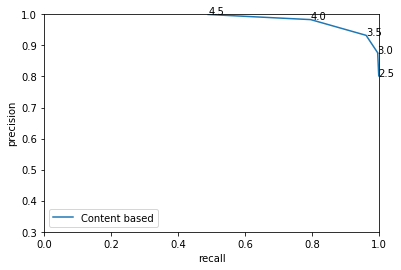

In [19]:
tresholds = [2.5, 3.0, 3.5, 4.0, 4.5]
treshold_used = 3.5
# CONTENT BASED
def conf_matrix(predicted, treshold_used, treshold_recommended):
    matrix = confusion(recommended(predicted, treshold_recommended), hidden(predicted, treshold_recommended), 
              used(predicted, treshold_used), unused(predicted, treshold_used))
    return (precision(matrix), recall(matrix))

precisons = [conf_matrix(prediction, treshold_used, x)[0] for x in tresholds]
recalls = [conf_matrix(prediction, treshold_used, x)[1] for x in tresholds]
plt.plot(recalls, precisons)
for r, p, t in zip(recalls, precisons, tresholds):
    plt.text(r, p, t)

    
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['Content based'], loc = 'lower left')

## Dissimilarity

In [30]:
def calculate_dissimilarity(top):
    
    # filter businesses in DF
    dissimilarity_categories = pd.read_pickle("./cosine_sim_categories.pkl")
    dissimilarity_categories = abs(round(1 - dissimilarity_categories, 5))
    dissimilarity_matrix = dissimilarity_categories.copy().reindex(index=top, columns=top)
    
    # Calculate dissimilarity
    dissimilarity = pd.DataFrame({'dissimilarity': dissimilarity_matrix.sum()/19 })
    
    return dissimilarity

def calculate_mean_dissimilarity(top):

    # filter businesses in DF
    dissimilarity_categories = pd.read_pickle("./cosine_sim_categories.pkl")
    dissimilarity_categories = abs(round(1 - dissimilarity_categories, 5))
    dissimilarity_matrix = dissimilarity_categories.copy().reindex(index=top, columns=top)
    
    # Calculate dissimilarity
    dissimilarity = pd.DataFrame({'dissimilarity': dissimilarity_matrix.sum()/19 })
    
    # Calculate mean dissimilarity
    mean_dissimilarity = dissimilarity['dissimilarity'].mean()
    
    return mean_dissimilarity

# TESTS
recommendations = get_recommended('QaN-nccbLZPWzownQYgTVQ', 20, rec = review)['business_id'].to_list()
display(calculate_mean_dissimilarity(recommendations))

0.7787068421052632

0.7459819571603428

{'whiskers': [<matplotlib.lines.Line2D at 0x1a2fcd3750>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2ba5ea90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2fcd3090>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2d8e2e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2b91fbd0>],
 'means': []}

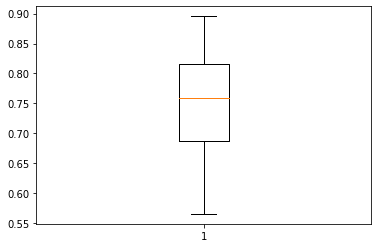

In [27]:
# Take more dissimilarity-averages from 50 different users. Afther that, make a boxplot of it to visualize. 
dissimilarity_plot = []
for user in test_set['user_id'].head(50):
    if get_recommended(user, 20, rec = review).empty == False:
        dissimilarity_plot.append(calculate_mean_dissimilarity(get_recommended(user, 20, rec = review)['business_id'].to_list()))

display(sum(dissimilarity_plot) / len(dissimilarity_plot))   
plt.boxplot(dissimilarity_plot)